### Model assessment
Here we compared the weights learned by several model iterations, to highlight
- Performance user parameter combinations
- Interpretation based on TF regulators
- Coherence or learned graph-weights when assisting RNA-weights, or only using ATAC-weights

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
!readlink -f .

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


In [4]:
import torch
import mubind as mb
import scanpy as sc

In [5]:
!ls -ltrh /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022*

-rw-rw-r-- 1 ilibarra ilibarra  18M Jun 10 02:06 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_use_logdynamic_0.pth
-rw-rw-r-- 1 ilibarra ilibarra  21M Jun 10 02:06 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_use_logdynamic_1.pth
-rw-rw-r-- 1 ilibarra ilibarra 909M Jun 10 02:06 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_sample_train.h5ad
-rw-rw-r-- 1 ilibarra ilibarra 1.5M Jun 11 01:20 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_use_logdynamic_0_obs386.pth
-rw-rw-r-- 1 ilibarra ilibarra 1.6M Jun 11 01:20 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_use_logdynamic_1_obs386.pth
-rw-rw-r-- 1 ilibarra ilibarra  58M Jun 11 01:20 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_sample_train_obs386.h5ad
-rw-rw-r-- 1 ilibarra ilibarra  18M Jun 13 02:51 /home/ilibarra/workspace/theislab/mubind/d

In [6]:
# query
obs_id = 7468


# load models
model_by_logdynamic = {}
for use_logdynamic in [False, True]:
    p = 'noack_2022_use_logdynamic_%i_obs%s.pth' % (use_logdynamic, obs_id)
    print(p)
    model_by_logdynamic[use_logdynamic] = torch.load(p)

noack_2022_use_logdynamic_0_obs7468.pth
noack_2022_use_logdynamic_1_obs7468.pth


In [7]:
ad = sc.read_h5ad('noack_2022_sample_train_obs%s.h5ad' % obs_id)
# ad = sc.read_h5ad('atac_train.h5ad')
#rna_sample = sc.read_h5ad('rna_sample_train.h5ad')
rna_sample = ad

In [8]:
rna_sample.shape

(7468, 1948)

In [9]:
import pickle
train = pickle.load(open('train_dataloader_obs%s.pkl' % obs_id, 'rb'))

In [10]:
%load_ext line_profiler

In [11]:
# # load the pancreas multiome dataset
# rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')


In [12]:
# %lprun -f model.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [13]:
# %lprun -f model.binding_modes.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [14]:
import matplotlib.pyplot as plt

False
True
3
order None
0 out of 288...
break


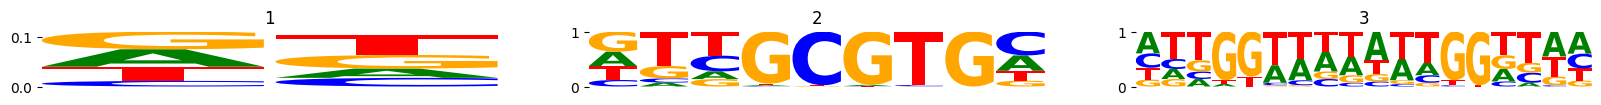

True
True
3
order None
0 out of 288...
break


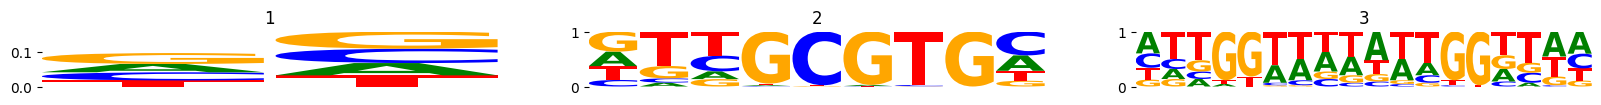

In [15]:

for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.logo(model, n_cols=3, show=True, n_rows=6, stop_at=4) #  log=True)
    plt.show()


True


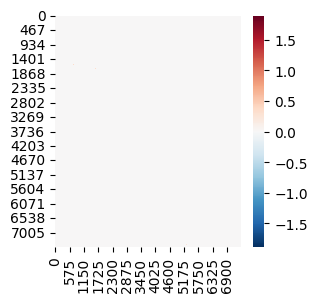

In [16]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.graph_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.graph_module.log_dynamic
    D = model.graph_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns
    mb.pl.set_rcParams({'figure.figsize': [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')
    plt.show()

In [17]:
model = model_by_logdynamic[1]

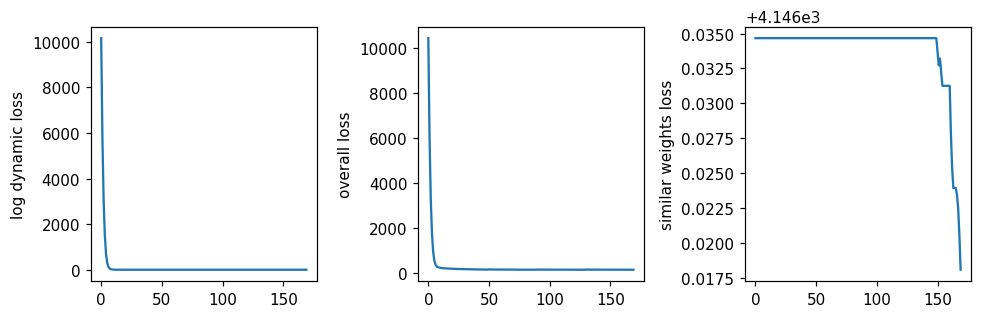

In [18]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd
import numpy as np

False
True


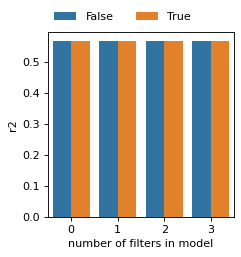

In [20]:
rcParams['figure.figsize'] = 3, 5
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_all.append(r2)

if len(r2_all) > 0:
    r2_all = pd.concat(r2_all)
    rcParams['figure.figsize'] = 3, 3
    rcParams['figure.dpi'] = 80
    ax = sns.barplot(data=r2_all, x='index', y='r2', hue='opt_log_dynamic', )
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.4, 1), ncol=3, title=None, frameon=False)

    plt.xlabel('number of filters in model')
    plt.show()

In [21]:

model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2


In [22]:
ad.obs['dynamic_score'].describe()

count    7468.000000
mean        0.441310
std         0.045827
min         0.000000
25%         0.441304
50%         0.441310
75%         0.441316
max         1.000000
Name: dynamic_score, dtype: float64

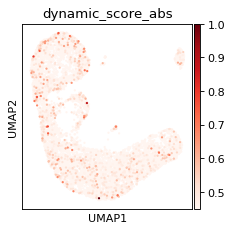

In [23]:
ad.obs['dynamic_score_abs'] = ad.obs['dynamic_score'].abs()
sc.pl.umap(ad, color='dynamic_score_abs', color_map='Reds', vmin=.45)

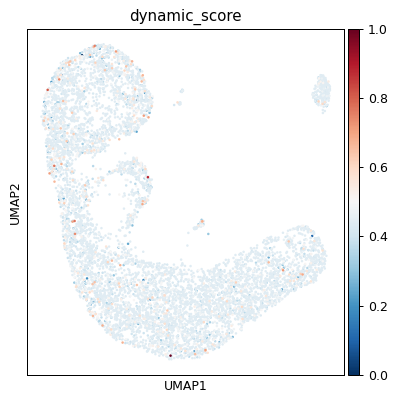

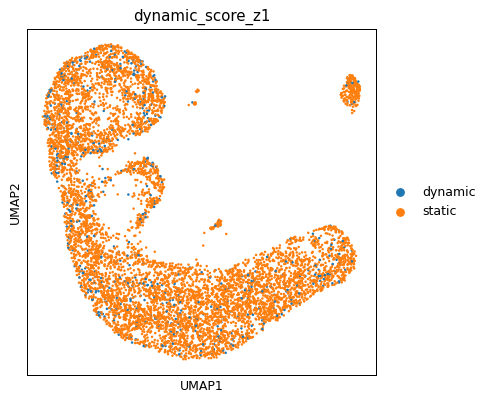

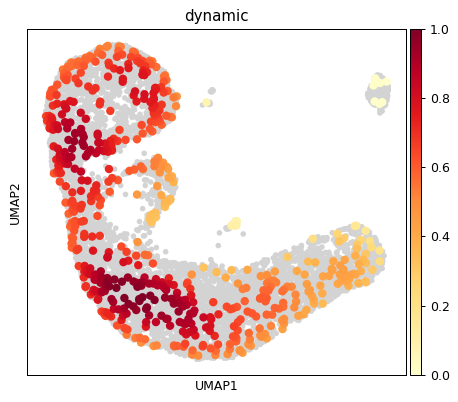

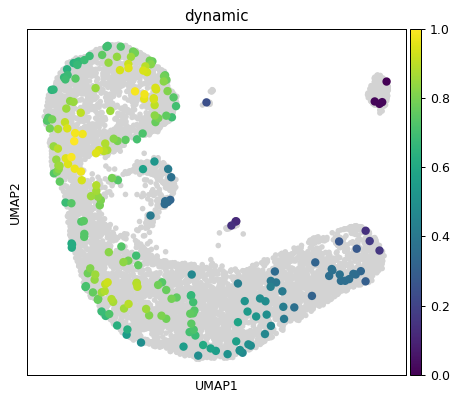

In [24]:


# contributions per newly added kernel
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic', color_map='viridis') # basis='umap', groupby='dynamic_score_cluster')

<Axes: >

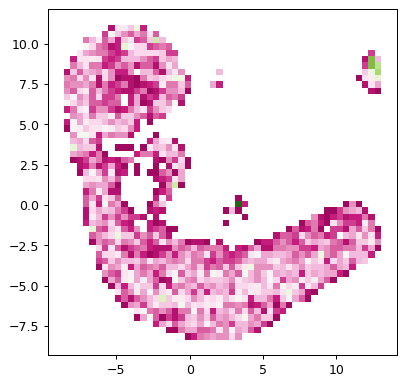

In [25]:
import seaborn as sns
umap = ad.obsm['X_umap']
sns.histplot(x=umap[:, 0], y=umap[:, 1], bins=50, cmap='PiYG')

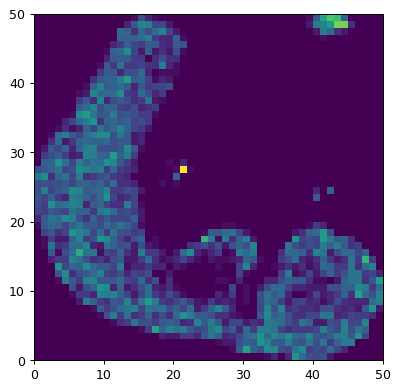

In [26]:
plt.pcolormesh(
    np.histogram2d(umap[:, 0], umap[:, 1], bins=50)[0]
)

In [27]:
x, y = np.meshgrid(umap[:, 0], umap[:, 1])

In [28]:
x = umap[:,1] # array_txt[:,0]
y = umap[:,1] # array_txt[:,1]
z = ad.obs['dynamic_score'].values # array_txt[:,2]


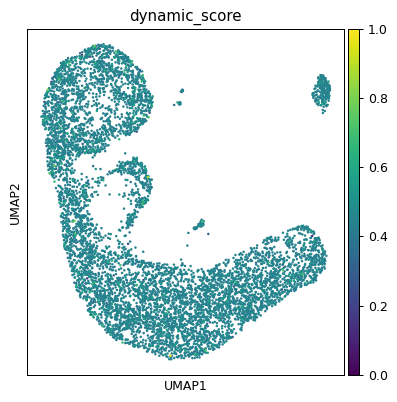

In [29]:
sc.pl.umap(ad, color='dynamic_score')

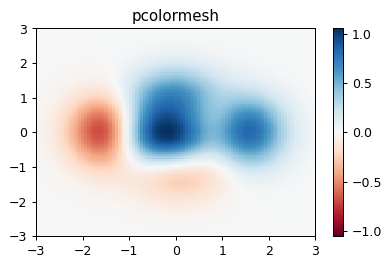

In [30]:
import matplotlib.pyplot as plt
import numpy as np
rcParams['figure.figsize'] = 5, 3

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [31]:
import itertools
import numpy as np

def grid(x, y, z, size_x=1, size_y=1):

    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    minx, maxx = int(min(x)), int(max(x)) + 1
    miny, maxy = int(min(y)), int(max(y)) + 1

    result = []
    x_edges = pairwise(np.arange(minx, maxx + 1, size_x))
    for xleft, xright in x_edges:
        xmask = np.logical_and(x >= xleft, x < xright)
        y_edges = pairwise(np.arange(miny, maxy + 1, size_y))
        for yleft, yright in y_edges:
            ymask = np.logical_and(y >= yleft, y < yright)
            cell = z[np.logical_and(xmask, ymask)]
            result.append(cell.sum())

    result = np.array(result).reshape((maxx - minx, maxy - miny))
    return np.flip(result.T, 0)


In [32]:
cell_type_key = 'clusters'

In [33]:
grid_dyn_score = grid(umap[:,0], umap[:,1], ad.obs['dynamic_score'], size_x=1, size_y=1)
grid_counts = grid(umap[:,0], umap[:,1], ad.obs[cell_type_key].cat.codes.values, size_x=1, size_y=1)

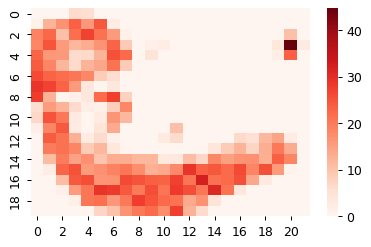

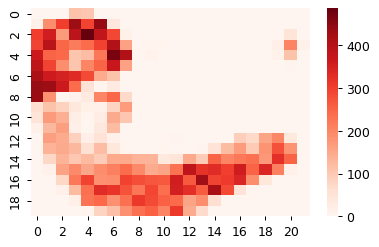

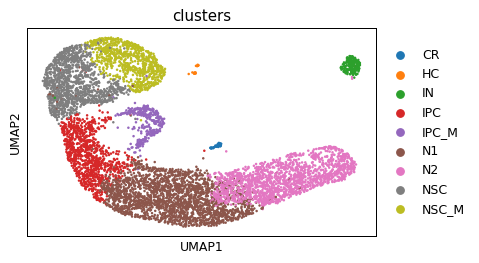

In [34]:

sns.heatmap(grid_dyn_score, cmap='Reds')
plt.show()
sns.heatmap(grid_counts, cmap='Reds')
plt.show()

sc.pl.umap(ad, color=cell_type_key)

In [35]:
# for optimize_log_dynamic in model_by_logdynamic:
#     mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
#     print(optimize_log_dynamic)
#     model = model_by_logdynamic[optimize_log_dynamic]
#     mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
#     plt.show()

#     mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
#     mb.pl.logo(model,
#                title=False,
#                xticks=False,
#                rowspan_dinuc=0,
#                rowspan_mono=1,
#                n_rows=12,
#                n_cols=3,
#                stop_at=20) # n_cols=len(reduced_groups))
#     plt.show()


In [36]:
model = model_by_logdynamic[True]

In [37]:
G = model.graph_module.conn_sparse.detach().cpu().to_dense() # (C, C)

In [38]:
# number of non_zero weights
len(G[G != 0])

144504

In [39]:
# output = model(**inputs, use_conn=False, return_binding_scores=True)

In [40]:
print('here...')

here...


In [41]:
ad

AnnData object with n_obs × n_vars = 7468 × 1948
    obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'louvain', 'clusters', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_alignment_scaling', 'chrom', 'pos', 'strand', 'tss_start', 'tss_end', 'chromosome_name', 'k', 'acc_score', 'acc_score_rank', 'chr', 'summit.start', 'summit.end', 'k.summit'
    uns: 'clusters_colors', 'louvain', 'lo

In [42]:
model = model.cuda()

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
# device

In [44]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [45]:
train

In [46]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic].cuda()

    umap = ad.obsm['X_umap'].copy()
    umap = np.sort(umap, 0)

    x = umap[:,0]
    y = umap[:,1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                      "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs['scale_countsum'] = model.datatype == 'selex'

        
        output = model(**inputs, use_conn=False, return_binding_scores=True)

        output = output.cpu().detach().numpy()
        print('here...')
        print(output.shape)

        print(output.sum())
        pred.append(output)

    # pred = np.concatenate(pred).T

    binding_scores = np.concatenate(pred).T


    # ad.layers['velocity'] = pred
    
    # conn = model.graph_module.conn_sparse.detach().cpu()
    # conn = model.graph_module.conn_sparse.detach().cpu().to_dense()
    # v = conn.sum(axis=1)
    # ad.layers['velocity'] = torch.stack([v,] * ad.shape[1], axis=1).numpy()
    
    # ad.layers['counts'] = ad.X

    # mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    # plt.hist(model.graph_module.conn_sparse.values().detach().cpu().numpy())
    # plt.show()

    # import scvelo as scv

    # sc.pp.neighbors(ad)

    # # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # # ad.layers['velocity'] = ad.obs['dynamic_score']
    
    # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)


X = ad.X.A
G @ binding_scores
np.random.shuffle(binding_scores)

False
True
here...
(256, 7468)
5585083000000.0
here...
(256, 7468)
5513163000000.0
here...
(256, 7468)
5683044000000.0
here...
(256, 7468)
7691195000000.0
here...
(256, 7468)
5453858000000.0
here...
(256, 7468)
4482980000000.0
here...
(256, 7468)
5052802000000.0
here...
(156, 7468)
1966114500000.0


In [47]:
import scvelo as scv

In [48]:
ad.shape, binding_scores.shape

((7468, 1948), (7468, 1948))

In [49]:
ad
ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

In [50]:
np.random.shuffle(binding_scores)
binding_scores

array([[2607858.5, 3069264.5, 2938833.2, ..., 1489139.6, 1601320.6,
        2731659.2],
       [2606504.8, 3067892.5, 2937390.8, ..., 1488873.9, 1601025.4,
        2731032.2],
       [2607542.8, 3068712.8, 2938544.5, ..., 1489093.5, 1601263.5,
        2731024. ],
       ...,
       [2607687.2, 3068737.2, 2938737.8, ..., 1489123.9, 1601298.4,
        2730984. ],
       [2607061. , 3068166.8, 2938023.5, ..., 1489017.1, 1601175.9,
        2730620. ],
       [2607702.8, 3068927. , 2938793.8, ..., 1489120.1, 1601294.5,
        2731031.2]], dtype=float32)

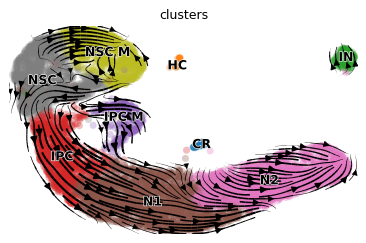

In [51]:
try:
    scv.pl.velocity_embedding_stream(rna_sample, color=cell_type_key)
except Exception:
    print("sample too small.")

In [52]:
# np.random.shuffle(binding_scores)
# ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

<Axes: >

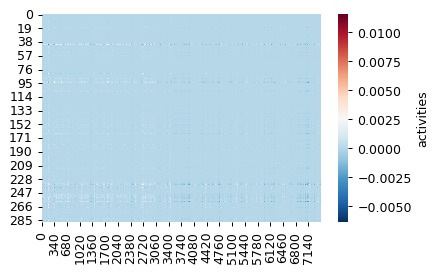

In [53]:
import seaborn as sns
act = model.get_log_activities().detach().cpu().squeeze(0)
sns.heatmap(act, cmap='RdBu_r', cbar_kws={'label': 'activities'})

tensor([ 93, 165, 234, 249, 255,  94, 236, 239, 251, 259, 265, 179,  53, 235,
         41])


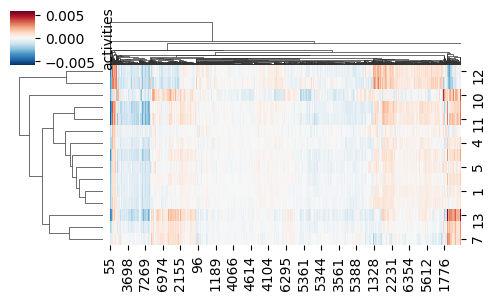

In [54]:
# highlight the top-n filters per cell, with the top variability
rcParams['figure.dpi'] = 100
n_show = 15
print(act.var(axis=1).sort()[1][-n_show:])
act_sel = act[act.var(axis=1).sort()[1][-n_show:],:]
vmax = act_sel.abs().max()
sns.clustermap(act_sel,
               vmin=-vmax / 2, vmax=vmax / 2,
               cmap='RdBu_r',
               
               cbar_kws={'label': 'activities'},
               figsize=[5, 3])


In [55]:
rna_sample.layers['velocity'].shape, rna_sample.shape

((7468, 1948), (7468, 1948))

In [56]:
# scv.pl.velocity_graph(rna_sample)

In [57]:

# ax = scv.pl.velocity_embedding_stream(ad,
#                                       color='celltype',
#                                       # density=2,
#                                       arrow_color='black',
#                                       n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [58]:
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', density=2, arrow_color='black', n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [59]:
# scv.pl.velocity_embedding_stream(ad, color='celltype', n_neighbors=15) #  X_grid='X_umap', V=V)

## Study the asssociations betweeen obtained weights and cluster-specific transcription factors

Load information from archetypes DB (Vierstra et al 2020)

In [60]:
rna_sample, ad.shape

(AnnData object with n_obs × n_vars = 7468 × 1948
     obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'louvain', 'clusters', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_alignment_scaling', 'chrom', 'pos', 'strand', 'tss_start', 'tss_end', 'chromosome_name', 'k', 'acc_score', 'acc_score_rank', 'chr', 'summit.start', 'summit.end', 'k.summit'
     uns: 'clusters_colors', 'louvain',

In [61]:
rna_sel = rna_sample # rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape

(7468, 1948)

In [62]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [63]:
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'

anno = mb.datasets.archetypes_anno()

In [64]:
rna_sel.shape
anno.sort_values('Cluster_ID')

Cluster_ID          Name          DBD             Seed_motif  \
61            1          HD/1  homeodomain     LHX6_homeodomain_3   
72            2          HD/2  homeodomain          ALX3_MA0634.1   
79            3          HD/3  homeodomain    VENTX_homeodomain_2   
80            4          HD/4  homeodomain  BARX1_MOUSE.H11MO.0.C   
81            5          HD/5  homeodomain    BARX1_homeodomain_1   
..          ...           ...          ...                    ...   
163         282         PAX/2          PAX   PAX5_HUMAN.H11MO.0.A   
161         283  PAX-halfsite          PAX          Pax2_MA0067.1   
0           284           AHR         bHLH    AHR_HUMAN.H11MO.0.B   
105         285      KLF/SP/3         C2H2   KLF8_HUMAN.H11MO.0.C   
285         286        ZSCAN4         C2H2          ZSCAN4_C2H2_1   

     Total_width  Consensus_left  Consensus_right  Cluster_size  
61            12               0               12             2  
72            26               8               16           186  
79            21               3               20             1  
80            17               5               13            17  
81            21               2               18             6  
..           ...             ...              ...           ...  
163           24               4               21             3  
161            8               1                7             1  
0              9               2                8             3  
105            9               0                9             2  
285           15               1               14             2  

[286 rows x 8 columns]

False


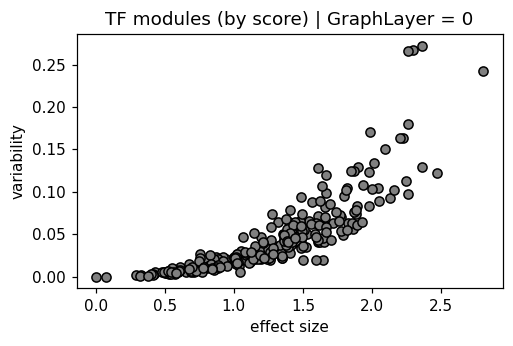

True


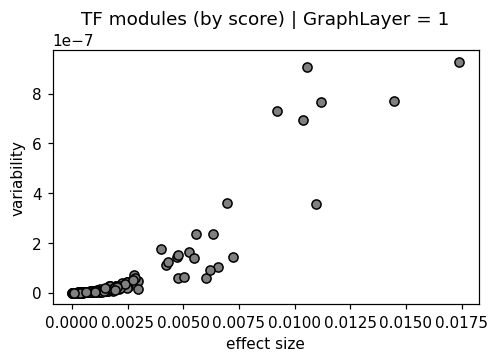

In [65]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 110})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var, color='gray', edgecolors='black')
    plt.xlabel('effect size')
    plt.ylabel('variability')
    plt.title('TF modules (by score) | GraphLayer = %i' % optimize_log_dynamic )
    plt.show()

In [66]:
# unique names for annotation
names = anno['Name'] # .sort_values('Name')
added = dict()
new_name = []
for name in names:
    if not name in added:
        new_name.append(name)
        added[name] = 0
    else:
        new_name.append(name + '_%i' % added[name])
        added[name] += 1
anno['Name_unique'] = new_name


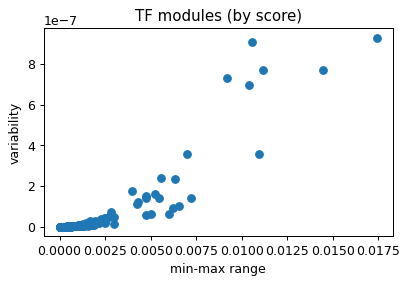

In [67]:
from scipy.stats import spearmanr
res = []
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue

    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    log_act.columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

    for c in log_act:
        a = log_act[c]
        b = ad.obs['dynamic_score'].values
        # print(a.shape, b.shape)
        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'spearman', 'p_val'])



In [68]:

# add archetypes name
meta = pd.DataFrame(pd.concat([delta, var], axis=1))
meta.columns = ['max_effect', 'variability']
meta['name'] = ['intercept', 'dinuc_bias'] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
meta['archetypes_name'] = meta['name'].map(anno.set_index('Cluster_ID')['Name_unique'])
meta['archetypes_name'] = np.where(pd.isnull(meta['archetypes_name']), meta['name'], meta['archetypes_name'])

meta['archetypes_seed'] = meta['name'].map(anno.set_index('Cluster_ID')['Seed_motif'])

meta['filter_position'] = range(0, meta.shape[0])

In [69]:
meta = meta.sort_values('max_effect', ascending=0)
meta

res = res.merge(meta, left_on='archetype_id', right_on='name')
res = res.sort_values('p_val', ascending=True)

In [70]:
name_by_filter_id = meta['archetypes_name'].to_dict()
# name_by_filter_id

## Observe general scores per case

<Axes: xlabel='max_effect', ylabel='archetypes_name'>

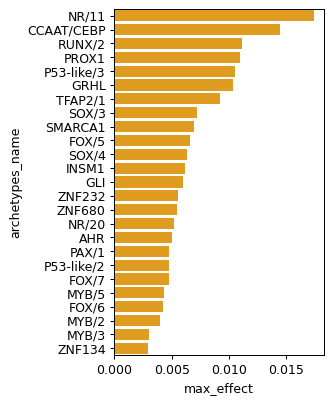

In [71]:
rcParams['figure.figsize'] =3, 5
sns.barplot(data=res.sort_values('max_effect', ascending=False).head(25), x='max_effect', y='archetypes_name', color='orange')

In [72]:
res

opt_log_dynamic archetype_id  spearman         p_val  max_effect  \
81              True           80 -0.083195  5.984632e-13    0.006570   
63              True           62 -0.080721  2.829112e-12    0.000325   
70              True           69 -0.074886  9.206159e-11    0.000218   
102             True          101 -0.072495  3.564266e-10    0.000488   
68              True           67 -0.072299  3.973564e-10    0.000231   
..               ...          ...       ...           ...         ...   
132             True          131  0.000932  9.357917e-01    0.000265   
254             True          253  0.000891  9.386534e-01    0.000078   
276             True          275  0.000745  9.486837e-01    0.002727   
121             True          120 -0.000302  9.791515e-01    0.000315   
251             True          250 -0.000084  9.942364e-01    0.006975   

      variability name archetypes_name        archetypes_seed  filter_position  
81   1.025107e-07   80           FOX/5       FOXC1_forkhead_1               81  
63   2.166844e-10   62     Ebox/CATATG     Atoh1.mouse_bHLH_1               63  
70   1.651290e-10   69            MIES         MEIS1_MA0498.2               70  
102  1.018540e-09  101          NFAC/2  NFAC1_HUMAN.H11MO.0.B              102  
68   1.678908e-10   67           SNAI2           SNAI2_C2H2_1               68  
..            ...  ...             ...                    ...              ...  
132  3.982126e-10  131           PRDM9  PRDM9_MOUSE.H11MO.0.C              132  
254  2.854675e-11  253           MYB/1         MYBL1_MA0776.1              254  
276  4.926435e-08  275        HINFP1/2          HINFP1_C2H2_2              276  
121  5.268340e-10  120            LEF1   LEF1_HUMAN.H11MO.0.A              121  
251  3.591204e-07  250         SMARCA1  SMCA1_HUMAN.H11MO.0.C              251  

[288 rows x 10 columns]

True
1
order None
0 out of 288...
10 out of 288...
break


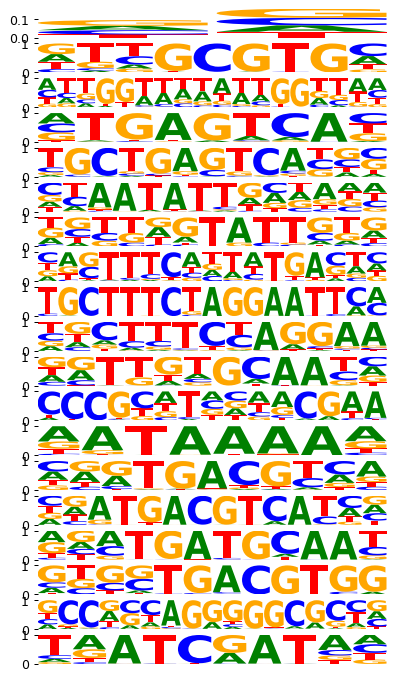

In [73]:
# visualize the logos as obtained by the model in each step
mb.pl.set_rcParams({'figure.figsize': [5, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20)
           # n_rows=len(res.head(20).index),

True
1
order Index([ 81,  63,  70, 102,  68,  72, 168, 264, 197,  11,  75,  85, 248,  21,
       162,  67, 120, 208, 198, 281],
      dtype='int64')
0 out of 288...
10 out of 288...


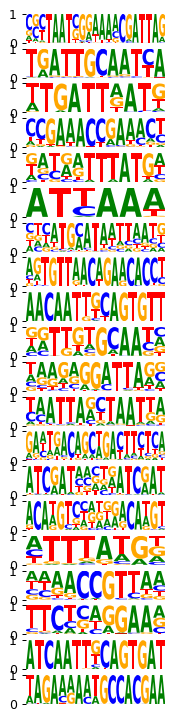

<Figure size 180x1800 with 0 Axes>

In [74]:
mb.pl.set_rcParams({'figure.figsize': [2, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40,
           # n_rows=len(res.head(20).index),
           n_cols=1, order=res.head(20).index) # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [75]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 7.11722


In [76]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')


In [77]:
rna_sel.obsm['X_umap'] = ad.obsm['X_umap']

In [78]:
def find_varname(ad, k, shuffle=False):
    if not shuffle:
        return ad.var_names[ad.var_names.str.upper().str.contains(k.upper())]
    else:
        ad_sel = ad.var_names[ad.var_names.str.upper().str.contains(k.upper())]
        return pd.Series(ad.var_names).sample(ad_sel.shape[0]).values

In [80]:
from scipy.stats import spearmanr, pearsonr

Calculate global correlations between the activities obtained per motif and gene-specific expression

In [79]:

all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm['log_activities'].iloc[:,2:]:
        log_act = ad.obsm['log_activities'][k].values
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap='Reds')


False
True


In [81]:

def get_act_gene_corr(model_by_logdynamic, shuffle=False, random_state=0):
    print('association between motif activities and related TF targets (shuffle = %i)' % shuffle)
    res = []
    # print(len(all_targets))

    rna_sel_df = rna_sel.to_df()

    for optimize_log_dynamic in model_by_logdynamic:
        print('use GraphLayer = %i' % optimize_log_dynamic)
        model = model_by_logdynamic[optimize_log_dynamic]

        log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
        log_act = pd.DataFrame(log_act.detach().cpu().numpy())
        log_act.index = ad.obs_names

        ad.obsm['log_activities'] = log_act
        ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

        if shuffle:
            random_cols = ad.obsm['log_activities'].iloc[:,2:].columns.values
            np.random.shuffle(random_cols)
            # random_cols
        
        for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
            next_log_act = ad.obsm['log_activities'][k].values

            # if shuffle:
            #     next_log_act = ad.obsm['log_activities'][random_cols[ki]].values
            
            # print(ki)
            # if ki % 30 == 0:
            #     print(ki)
            names = set()
            clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
            for g in clu_sel:
                names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
            for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
                names.add(g.split('_')[0].split('.')[0])
            # print(k, names)
            next_targets = set()
            for name in names:
                target = find_varname(rna_sel, name, shuffle=shuffle)
                # print(name, target)
                for t in target:
                    next_targets.add(t)

            # for t in all_targets:
            for t in set(all_targets).intersection(next_targets):
                gex = rna_sel_df[[t]].to_numpy() # rna_sel_df[t].A
                assert gex.shape[1] == 1
                gex = gex.flatten()
                # print(next_log_act.shape, gex.shape)
                # print(t, pearsonr(next_log_act, gex))
                res.append([ki, optimize_log_dynamic, k, t, t in next_targets] +
                        list(spearmanr(next_log_act, gex)))
                
    res = pd.DataFrame(res, columns=['filter_id', 'opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

    # p-values
    res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
    res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])
    
    # p-val adjust
    from statsmodels.stats.multitest import fdrcorrection
    res['p_adj'] = fdrcorrection(res['p_val'])[1]
    return res


In [82]:
res = get_act_gene_corr(model_by_logdynamic)
shuffled = [get_act_gene_corr(model_by_logdynamic, shuffle=1, random_state=i) for i in range(10)]

association between motif activities and related TF targets (shuffle = 0)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLa

In [83]:
table = []
for use_graph in [False, True]:
    for thr in range(1, 10):
        sel = res[res['opt_log_dynamic'] == use_graph]
        next_thr = 10 ** (-thr)
        n_pos = sel[sel['p_adj'] < next_thr].shape[0]
        n_neg = [s[(s['p_adj'] < next_thr) & (s['opt_log_dynamic'] == use_graph)].shape[0] for s in shuffled]
        # print(next_thr, n_pos, np.mean(n_neg), np.std(n_neg), (n_pos - np.mean(n_neg)) / np.std(n_neg))
        table.append([next_thr, n_pos, np.mean(n_neg), np.std(n_neg), (n_pos - np.mean(n_neg)) / np.std(n_neg), use_graph])
table = pd.DataFrame(table, columns=['p_adj_thr', 'n_pos', 'mu', 'sigma', 'zscore', 'graph_layer'])
table.pivot(index='graph_layer', columns='p_adj_thr', values='zscore')

p_adj_thr    1.000000e-09  1.000000e-08  1.000000e-07  1.000000e-06  \
graph_layer                                                           
False           16.307306     17.210994     17.923689     19.300077   
True            16.771633     16.844823     18.867470     20.616539   

p_adj_thr    1.000000e-05  1.000000e-04  1.000000e-03  1.000000e-02  \
graph_layer                                                           
False           21.369533     21.025215     23.809716     29.448288   
True            20.391481     20.154788     22.081069     25.297435   

p_adj_thr    1.000000e-01  
graph_layer                
False           42.860716  
True            32.026265

In [84]:
res

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
0             0            False             1      Lhx6     True -0.000285   
1             1            False             2    Tsen15     True -0.001365   
2             1            False             2      Fen1     True  0.038232   
3             1            False             2      Dlx1     True -0.015191   
4             1            False             2      Emx2     True  0.037273   
...         ...              ...           ...       ...      ...       ...   
1439        263             True           264    Tfap2c     True  0.407313   
1440        272             True           273      Zic2     True  0.174856   
1441        272             True           273      Zic4     True  0.006769   
1442        272             True           273      Zic1     True  0.085284   
1443        280             True           281      Pax6     True -0.394307   

              p_val module_name          p_adj  
0      9.803618e-01        HD/1   9.803618e-01  
1      9.060966e-01        HD/2   9.124153e-01  
2      9.513215e-04        HD/2   1.235349e-03  
3      1.893084e-01        HD/2   2.077214e-01  
4      1.274696e-03        HD/2   1.641982e-03  
...             ...         ...            ...  
1439  1.799855e-296     TFAP2/1  4.998059e-295  
1440   2.393773e-52         ZIC   7.216300e-52  
1441   5.586499e-01         ZIC   5.786875e-01  
1442   1.556406e-13         ZIC   2.691557e-13  
1443  2.557552e-276       PAX/1  5.681701e-275  

[1444 rows x 9 columns]

Text(0.5, 1.0, 'associations between activity layer and TF (GEX)')

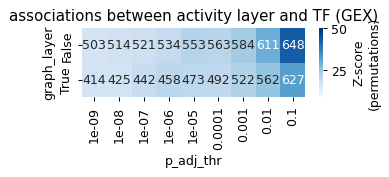

In [85]:
rcParams['figure.figsize'] = 4, 1
hm = table.pivot(index='graph_layer', columns='p_adj_thr', values='n_pos').fillna(0)
z = table.pivot(index='graph_layer', columns='p_adj_thr', values='zscore').fillna(0)
sns.heatmap(z, annot=hm, fmt='', cmap='Blues', cbar_kws={'label': 'Z-score\n(permutations)'},
            vmin=9,
            vmax=50)
plt.title('associations between activity layer and TF (GEX)')

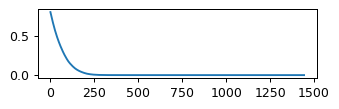

In [86]:
cumulative = np.cumsum(res.sort_values('p_adj')['p_adj']) / 100
plt.plot(range(len(cumulative)), cumulative[::-1])

In [87]:
shuffled[0].sort_values('p_val')

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
0           13            False             7   Kbtbd11     True  0.495315   
24          66            False            96    Tmsb10     True -0.662982   
196        245            False            70     Creb5     True  0.438224   
186        245            False            70       Ttk     True  0.449670   
184        245            False            70     Tubb3     True -0.602092   
..         ...              ...           ...       ...      ...       ...   
216        253            False            95      Pbx3     True  0.002614   
379        105             True            54     Neat1     True -0.002472   
283         52             True            70      Zic4     True  0.001666   
143        245            False            70    Pcmtd2     True  0.001222   
176        245            False            70      Ets1     True  0.000901   

        p_val module_name     p_adj  
0    0.000000        HD/7  0.000000  
24   0.000000       ETS/2  0.000000  
196  0.000000       TBX/1  0.000000  
186  0.000000       TBX/1  0.000000  
184  0.000000       TBX/1  0.000000  
..        ...         ...       ...  
216  0.821309         SPI  0.828949  
379  0.830862       AP1/1  0.836645  
283  0.885537       TBX/1  0.889636  
143  0.915926       TBX/1  0.918041  
176  0.937959       TBX/1  0.937959  

[434 rows x 9 columns]

In [88]:
res.sort_values('p_adj')

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
721         280            False           281      Pax6     True -0.573237   
428          69            False            70     Myt1l     True -0.483895   
410          69            False            70    Tuba1b     True  0.440131   
401          69            False            70    Nt5dc2     True  0.430145   
92           58            False            59      Hes1     True  0.538762   
...         ...              ...           ...       ...      ...       ...   
480          69            False            70   Galnt13     True  0.000696   
331          69            False            70  Cntnap5c     True -0.000668   
1195         69             True            70      Pltp     True -0.000298   
365          69            False            70     Ptprc     True  0.000288   
0             0            False             1      Lhx6     True -0.000285   

         p_val    module_name     p_adj  
721   0.000000          PAX/1  0.000000  
428   0.000000          TBX/1  0.000000  
410   0.000000          TBX/1  0.000000  
401   0.000000          TBX/1  0.000000  
92    0.000000  Ebox/CACGTG/2  0.000000  
...        ...            ...       ...  
480   0.952032          TBX/1  0.954677  
331   0.953970          TBX/1  0.955956  
1195  0.979453          TBX/1  0.980362  
365   0.980153          TBX/1  0.980362  
0     0.980362           HD/1  0.980362  

[1444 rows x 9 columns]

In [89]:
from statsmodels.stats.multitest import fdrcorrection
res['p_adj'] = fdrcorrection(res['p_val'])[1]
# res[res['p_adj'] < 0.1]

In [90]:
genes_by_module_name = res.groupby(['module_name'])['gene_name'].apply(lambda grp: list(grp.value_counts().index)).to_dict()
# genes_by_module_name

In [91]:
res.sort_values('p_adj')

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
721         280            False           281      Pax6     True -0.573237   
428          69            False            70     Myt1l     True -0.483895   
410          69            False            70    Tuba1b     True  0.440131   
401          69            False            70    Nt5dc2     True  0.430145   
92           58            False            59      Hes1     True  0.538762   
...         ...              ...           ...       ...      ...       ...   
480          69            False            70   Galnt13     True  0.000696   
331          69            False            70  Cntnap5c     True -0.000668   
1195         69             True            70      Pltp     True -0.000298   
365          69            False            70     Ptprc     True  0.000288   
0             0            False             1      Lhx6     True -0.000285   

         p_val    module_name     p_adj  
721   0.000000          PAX/1  0.000000  
428   0.000000          TBX/1  0.000000  
410   0.000000          TBX/1  0.000000  
401   0.000000          TBX/1  0.000000  
92    0.000000  Ebox/CACGTG/2  0.000000  
...        ...            ...       ...  
480   0.952032          TBX/1  0.954677  
331   0.953970          TBX/1  0.955956  
1195  0.979453          TBX/1  0.980362  
365   0.980153          TBX/1  0.980362  
0     0.980362           HD/1  0.980362  

[1444 rows x 9 columns]

In [92]:
res['k'] = res['gene_name'] + '_' + res['archetype_id'].astype(str)
df2 = res.pivot(index='k', columns='opt_log_dynamic', values='spearman')
# df2 = res # .pivot(index='k', columns='opt_log_dynamic', values='spearman')

In [93]:
df2

opt_log_dynamic     False     True 
k                                  
Abat_70         -0.042521 -0.010281
Abracl_70       -0.204857 -0.050106
Acot1_32         0.257105 -0.044488
Acot1_41         0.223184 -0.059123
Acot1_70         0.373387  0.008288
...                   ...       ...
Zfp536_257       0.058954  0.166183
Zic1_110        -0.018584 -0.001592
Zic1_273         0.013229  0.085284
Zic2_273        -0.025650  0.174856
Zic4_273         0.010997  0.006769

[722 rows x 2 columns]

In [94]:
mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 120})
# df2 = df2.sort_values('matched', ascending=True)
# plt.scatter(df2[True], df2[True],
#             color=np.where(df2['matched'], 'blue', 'gray'),
#             s=np.where(df2['matched'], 30, 5))
# plt.xlabel('TF activity (graph = off)')
# plt.ylabel('TF activity (graph = on)')
# plt.axhline(0, color='gray', ls='--', zorder=0)
# plt.axvline(0, color='gray', ls='--', zorder=0)


In [95]:
# df2[df2['matched'] == True].sort_values(True, ascending=False)

In [96]:
# res['arch_name'] = name_by_filter_id

In [97]:
res.sort_values('p_adj')

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
721         280            False           281      Pax6     True -0.573237   
428          69            False            70     Myt1l     True -0.483895   
410          69            False            70    Tuba1b     True  0.440131   
401          69            False            70    Nt5dc2     True  0.430145   
92           58            False            59      Hes1     True  0.538762   
...         ...              ...           ...       ...      ...       ...   
480          69            False            70   Galnt13     True  0.000696   
331          69            False            70  Cntnap5c     True -0.000668   
1195         69             True            70      Pltp     True -0.000298   
365          69            False            70     Ptprc     True  0.000288   
0             0            False             1      Lhx6     True -0.000285   

         p_val    module_name     p_adj            k  
721   0.000000          PAX/1  0.000000     Pax6_281  
428   0.000000          TBX/1  0.000000     Myt1l_70  
410   0.000000          TBX/1  0.000000    Tuba1b_70  
401   0.000000          TBX/1  0.000000    Nt5dc2_70  
92    0.000000  Ebox/CACGTG/2  0.000000      Hes1_59  
...        ...            ...       ...          ...  
480   0.952032          TBX/1  0.954677   Galnt13_70  
331   0.953970          TBX/1  0.955956  Cntnap5c_70  
1195  0.979453          TBX/1  0.980362      Pltp_70  
365   0.980153          TBX/1  0.980362     Ptprc_70  
0     0.980362           HD/1  0.980362       Lhx6_1  

[1444 rows x 10 columns]

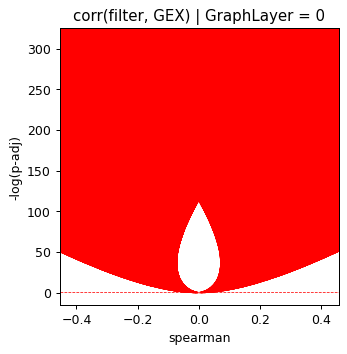

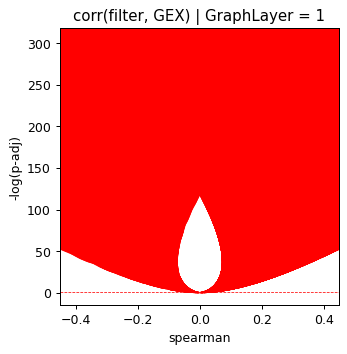

In [98]:
rcParams['figure.figsize'] = 4, 4
rcParams['figure.dpi'] = 90

for optimize_log_dynamic, grp in res.groupby('opt_log_dynamic'):
    grp['minus_log10_pval'] = -np.log10(grp['p_val'])
    grp = grp.sort_values('matched')
    plt.scatter(grp['spearman'], grp['minus_log10_pval'],
                s=np.power(grp['minus_log10_pval'], 2), color=np.where(grp['matched'], 'red', 'blue'))
    plt.ylabel('-log(p-adj)')
    plt.xlabel('spearman')
    plt.title('corr(filter, GEX) | GraphLayer = %i' % optimize_log_dynamic)
    plt.axhline(1, ls='--', color='red', lw=0.6)
    plt.show()

<Axes: xlabel='spearman', ylabel='Count'>

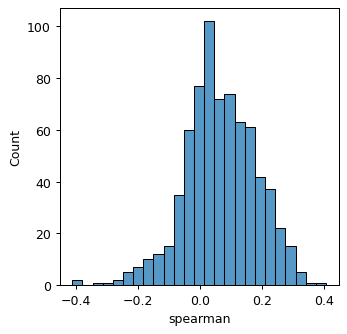

In [99]:
sns.histplot(grp['spearman'])

In [100]:
# sc.pl.umap(ad, color=[96], cmap='RdBu_r')
# sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

Text(0, 0.5, '# associations')

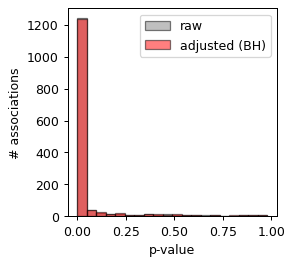

In [101]:
rcParams['figure.figsize'] = 3, 3
rcParams['figure.dpi'] = 90
plt.hist(res['p_val'], color='gray', bins=20, label='raw', alpha=.5, edgecolor = 'black')
plt.hist(res['p_adj'], color='red', bins=20, label='adjusted (BH)', alpha=.5, edgecolor = 'black')
plt.xlabel('p-value')
plt.legend()
plt.ylabel('# associations')

In [102]:
res[res['p_adj'] < 0.05]

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
2             1            False             2      Fen1     True  0.038232   
4             1            False             2      Emx2     True  0.037273   
7             1            False             2      Emx1     True -0.107741   
8             1            False             2      Lhx2     True -0.072531   
9             1            False             2     Lmx1a     True -0.038563   
...         ...              ...           ...       ...      ...       ...   
1438        262             True           263    Tfap2c     True  0.180294   
1439        263             True           264    Tfap2c     True  0.407313   
1440        272             True           273      Zic2     True  0.174856   
1442        272             True           273      Zic1     True  0.085284   
1443        280             True           281      Pax6     True -0.394307   

              p_val module_name          p_adj           k  
2      9.513215e-04        HD/2   1.235349e-03      Fen1_2  
4      1.274696e-03        HD/2   1.641982e-03      Emx2_2  
7      9.970674e-21        HD/2   1.953549e-20      Emx1_2  
8      3.492181e-10        HD/2   5.535357e-10      Lhx2_2  
9      8.585953e-04        HD/2   1.116947e-03     Lmx1a_2  
...             ...         ...            ...         ...  
1438   1.357020e-55     TFAP2/2   4.250624e-55  Tfap2c_263  
1439  1.799855e-296     TFAP2/1  4.998059e-295  Tfap2c_264  
1440   2.393773e-52         ZIC   7.216300e-52    Zic2_273  
1442   1.556406e-13         ZIC   2.691557e-13    Zic1_273  
1443  2.557552e-276       PAX/1  5.681701e-275    Pax6_281  

[1238 rows x 10 columns]

In [103]:
pval_thr = 1e-5
sel_genes = set(list(res[res['p_adj'] < pval_thr]['gene_name']))

In [104]:
log_act = ad.obsm['log_activities'].copy()

In [105]:
cols_act = ['intercept', 'dinuc_bias'] + [name_by_filter_id[k] for k in log_act.columns[2:]]
log_act.columns = cols_act

In [106]:
import anndata
ad_act = anndata.AnnData(log_act)
ad_act.obsm['X_umap'] = ad.obsm['X_umap']
ad_act.obs = ad.obs

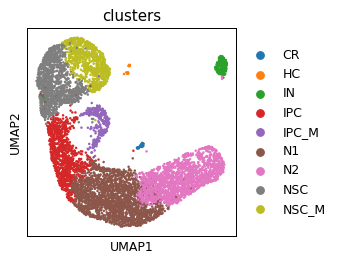

In [107]:
sc.pl.umap(ad_act, color=cell_type_key)


Rank genes groups using the annotation

In [108]:
sc.tl.rank_genes_groups(ad_act, cell_type_key)
rkg_df = []
for ct in ad_act.obs[cell_type_key].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2[cell_type_key] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df['module_name'] = rkg_df['names'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
rkg_df['module_name'] = np.where(~pd.isnull(rkg_df['module_name']), rkg_df['module_name'], rkg_df['names'])
rkg_df.head()

NSC_M
N1
IPC
NSC
IPC_M
N2
CR
HC
IN


names     scores  logfoldchanges          pvals      pvals_adj clusters  \
0     HEN1  45.165398             NaN  1.920844e-254  5.532031e-252    NSC_M   
1     SMAD  44.085663             NaN  2.024890e-236  2.915842e-234    NSC_M   
2    NFI/3  43.636154             NaN  5.765752e-230  5.535122e-228    NSC_M   
3   ZNF708  42.948746             NaN  1.048228e-225  5.031493e-224    NSC_M   
4  SPDEF/2  42.828644             NaN  2.098280e-223  6.043047e-222    NSC_M   

  module_name  
0        HEN1  
1        SMAD  
2       NFI/3  
3      ZNF708  
4     SPDEF/2

Get top modules

In [109]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index('names')['module_name'].to_dict())

In [110]:
sc.tl.rank_genes_groups(ad_act, cell_type_key)

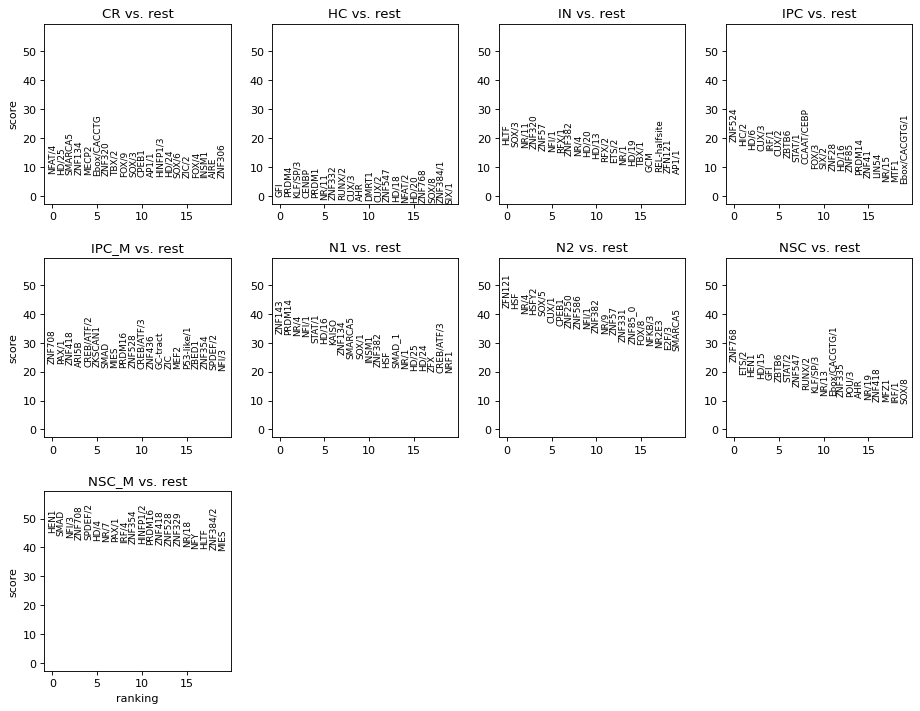

In [111]:
rcParams['figure.figsize'] = 3.5, 3.5
rcParams['figure.dpi'] = 80
sc.pl.rank_genes_groups(ad_act)


In [112]:
set(res[(res['p_adj'] < 1e-5)]['k'])

{'Abracl_70',
 'Acot1_32',
 'Acot1_41',
 'Acot1_70',
 'Acot7_70',
 'Actb_70',
 'Actl6b_70',
 'Actn1_70',
 'Actr3b_70',
 'Adamts18_70',
 'Adamts1_70',
 'Adamts5_70',
 'Amotl1_70',
 'Amotl2_70',
 'Arfgef3_248',
 'Arg2_248',
 'Arhgap11a_248',
 'Arhgap20_248',
 'Arhgap21_248',
 'Arhgap33_248',
 'Arhgef25_248',
 'Arhgef28_248',
 'Arhgef2_248',
 'Arid5b_248',
 'Arl4d_248',
 'Arl6ip1_248',
 'Arl6ip5_248',
 'Arl8a_248',
 'Arnt2_248',
 'Arnt2_58',
 'Arpc1b_248',
 'Arpp21_248',
 'Arrdc3_248',
 'Arsb_248',
 'Arx_2',
 'Arx_248',
 'Arx_8',
 'Ascl1_65',
 'Atad2_70',
 'Atad5_70',
 'Atcay_70',
 'Atf3_49',
 'Atf3_54',
 'Atf3_70',
 'Atl1_70',
 'Atp1a1_70',
 'Atp1a2_70',
 'Atp1a3_70',
 'Atp1b1_70',
 'Atp2b1_70',
 'Atp2b2_70',
 'Atp9a_70',
 'Atxn1_70',
 'Atxn7_70',
 'B3galt1_70',
 'B3galt2_70',
 'B3gat2_70',
 'B3glct_70',
 'Bach2_53',
 'Basp1_109',
 'Basp1_112',
 'Bcar1_248',
 'Btbd17_70',
 'Btg1_70',
 'Btg2_70',
 'C1qtnf4_70',
 'Car14_248',
 'Card19_248',
 'Carhsp1_248',
 'Carmil3_248',
 'Cbfa2t2_70',
 '

In [113]:
res[res['module_name'].str.contains('HD')].sort_values('p_adj')

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
16           6            False             7      Emx2     True -0.346246   
30          24            False            25      Otx1     True  0.344194   
17           6            False             7    Tsen15     True -0.342683   
741          7             True             8       Arx     True  0.294510   
19           7            False             8       Arx     True  0.252884   
15           6            False             7      Fen1     True -0.243924   
724          1             True             2      Fen1     True  0.206245   
728          1             True             2      Lhx6     True -0.142153   
734          1             True             2      Dlx2     True -0.141029   
725          1             True             2      Dlx1     True -0.136572   
727          1             True             2      Dlx5     True -0.131326   
18           6            False             7      Emx1     True  0.125908   
732          1             True             2    Draxin     True  0.123025   
737          6             True             7      Fen1     True  0.112698   
7            1            False             2      Emx1     True -0.107741   
10           1            False             2    Draxin     True  0.097319   
753         25             True            26      Otx1     True  0.073079   
8            1            False             2      Lhx2     True -0.072531   
726          1             True             2      Emx2     True  0.069194   
729          1             True             2      Emx1     True -0.067820   
723          1             True             2    Tsen15     True  0.066191   
752         24             True            25      Otx1     True  0.065346   
735          1             True             2       Arx     True -0.058945   
31          25            False            26      Otx1     True -0.045524   
738          6             True             7      Emx2     True  0.040169   
9            1            False             2     Lmx1a     True -0.038563   
2            1            False             2      Fen1     True  0.038232   
4            1            False             2      Emx2     True  0.037273   
13           1            False             2       Arx     True  0.035164   
739          6             True             7    Tsen15     True  0.027852   
733          1             True             2    Pou6f2     True  0.026297   
722          0             True             1      Lhx6     True -0.022639   
12           1            False             2      Dlx2     True -0.020923   
736          1             True             2      Lhx9     True  0.020837   
11           1            False             2    Pou6f2     True  0.020512   
6            1            False             2      Lhx6     True -0.020279   
14           1            False             2      Lhx9     True  0.016656   
3            1            False             2      Dlx1     True -0.015191   
731          1             True             2     Lmx1a     True -0.011043   
5            1            False             2      Dlx5     True  0.008994   
740          6             True             7      Emx1     True -0.008641   
730          1             True             2      Lhx2     True -0.007889   
20          11            False            12      Pbx3     True  0.005877   
742         11             True            12      Pbx3     True  0.001652   
1            1            False             2    Tsen15     True -0.001365   
0            0            False             1      Lhx6     True -0.000285   

             p_val module_name          p_adj         k  
16   2.451831e-209        HD/7  3.404273e-208    Emx2_7  
30   9.966893e-207       HD/19  1.320385e-205   Otx1_25  
17   8.098549e-205        HD/7  1.063119e-203  Tsen15_7  
741  2.521271e-149        HD/8  2.154269e-148     Arx_8  
19   2.633395e-109        HD/8  1.503013e-108   

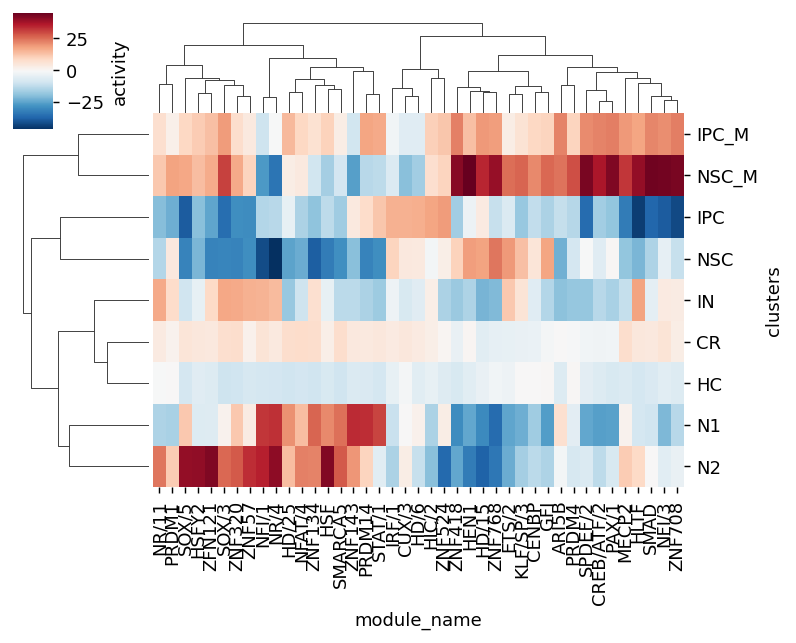

In [138]:
mod_names_best = set(rkg_df.sort_values('scores', ascending=False).groupby(cell_type_key).head(5)['module_name'])
best = rkg_df[rkg_df['module_name'].isin(mod_names_best)]
rcParams['figure.dpi'] = 130
sns.clustermap(best.pivot(index=cell_type_key, columns='module_name', values='scores'),
               cbar_kws={'label': 'activity'}, cmap='RdBu_r',
               # vmin=-5, vmax=5,
               figsize=[6.2, 5],
               # dpi=100,
               xticklabels=True)


In [139]:
rna_tfs = rna_sel.to_df()[list(set(res['gene_name']))]
rna_tfs[cell_type_key] = rna_sel.obs[cell_type_key]
mean_tfs = rna_tfs.groupby(cell_type_key).mean()

act_tfs_df = ad_act.to_df()
act_tfs_df[cell_type_key] = ad_act.obs[cell_type_key]
mean_act_tf = act_tfs_df.groupby(cell_type_key).mean()

In [140]:
corr_celltype = []
for i, c1 in enumerate(mean_act_tf):
    if i % 50 == 0:
        print(i, mean_act_tf.shape[1])
    for j, c2 in enumerate(mean_tfs):
        if not c1 in genes_by_module_name or not c2 in genes_by_module_name[c1]:
            continue
        a = mean_act_tf[c1]
        b = mean_tfs[c2]
        corr_celltype.append([c1, c2, mean_act_tf.index[np.argmax(mean_act_tf[c1])]] + list(pearsonr(a, b)))

corr = pd.DataFrame(corr_celltype,
                    columns=['module_name', 'gene_name', 'cell_type', 'pearsonr', 'p_val'])
corr = corr.sort_values('pearsonr', ascending=False)


0 288
50 288
100 288
150 288
200 288
250 288


In [141]:
# sc.pl.dotplot(rna_sel, groupby='celltype', var_names=list(set(res['gene_name'])))

In [142]:
corr[corr['pearsonr'] > 0].sort_values('p_val')

module_name gene_name cell_type  pearsonr     p_val
718       ETS/1     Terf1     IPC_M  0.858008  0.003083
337       TBX/1      Ptma     NSC_M  0.844447  0.004183
182       SOX/8      Sox9     NSC_M  0.834275  0.005167
329       TBX/1     Oxct1     NSC_M  0.828326  0.005810
66        NR/20  Arhgap21     IPC_M  0.779284  0.013301
..          ...       ...       ...       ...       ...
308       TBX/1    Mettl1     NSC_M  0.004067  0.991715
28         HD/2      Lhx6     NSC_M  0.001278  0.997396
325       TBX/1    Sptan1     NSC_M  0.001059  0.997843
680        NR/9     Nr4a2        CR  0.000707  0.998560
26         HD/2      Dlx1     NSC_M  0.000473  0.999036

[480 rows x 5 columns]

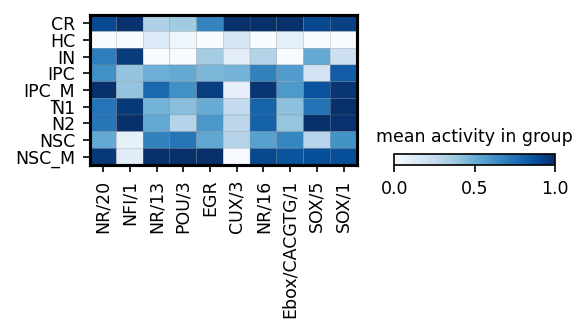

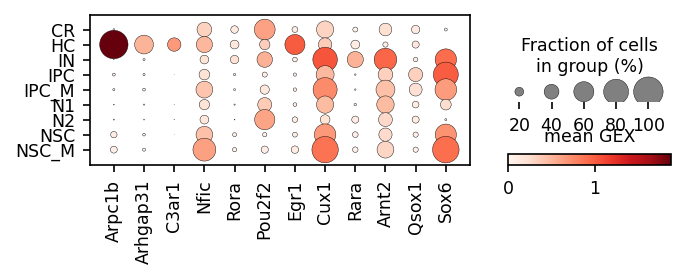

In [143]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 150
# repressors
module_names = corr[corr['pearsonr'] < 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr[corr['pearsonr'] < 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['gene_name']
sc.pl.matrixplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            var_names=module_names,
            figsize=[4, 1.3],
            standard_scale='var',
            colorbar_title='mean activity in group')
sc.pl.dotplot(rna_sel,
              groupby=cell_type_key,
              colorbar_title='mean GEX',
              var_names=gene_names,
              figsize=[5, 1.3])
# activators

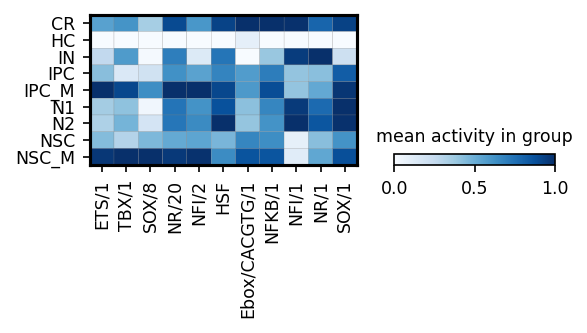

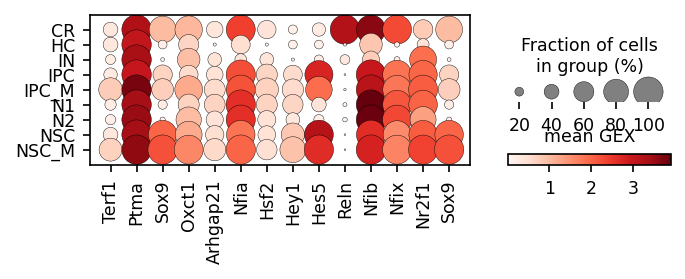

In [144]:

module_names = corr[corr['pearsonr'] > 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr[corr['pearsonr'] > 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['gene_name']
sc.pl.matrixplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            var_names=module_names,
            figsize=[4, 1.3],
            standard_scale='var',
            colorbar_title='mean activity in group')
sc.pl.dotplot(rna_sel,
              groupby=cell_type_key,
              colorbar_title='mean GEX',
              var_names=gene_names,
              figsize=[5, 1.3])



## Filter activities versus graph activities

In [146]:
A = model.get_log_activities()
sum_A = A.abs().sum(axis=1).cpu().detach().numpy()
A = A.squeeze(0)
print(A.shape)

torch.Size([288, 7468])


In [147]:
# this function assesses the contributions of A on the graph
indices, contributions, max_eig = mb.tl.compute_contributions(A, C * D)

contributions_normalized = torch.abs(contributions) / max_eig
contributions_df = pd.DataFrame(contributions_normalized.detach(), columns=['index'])
print("Summary statistics of the normalized contributions: \n")
contributions_df.describe()

Summary statistics of the normalized contributions: 



index
count  288.000000
mean     0.165232
std      0.046481
min      0.095960
25%      0.123591
50%      0.159016
75%      0.203710
max      0.268027

In [148]:
contributions.shape

torch.Size([288])

Percentage of non-zero entries of the filter matrix A: 100.0 %
(288,) (288,)


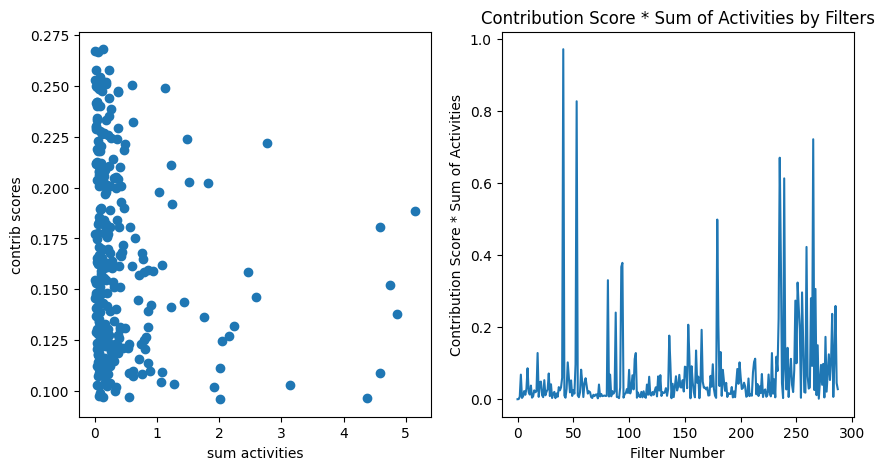

In [149]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 100
plt.figure(figsize=(10, 5))

print(f"Percentage of non-zero entries of the filter matrix A: {100 * torch.sum(A != 0).item() / A.numel()} %")
mb.pl.filter_contrib_simple(contributions_normalized, A.cpu())

In [150]:
# normalize the data, and look at summary stats
sum_A_norm = sum_A / np.max(sum_A)
sum_A_df = pd.DataFrame(sum_A.T, columns=['sum_A'])
sum_A_df.describe()

sum_A
count  7468.000000
mean      0.017057
std       0.013482
min       0.001479
25%       0.008304
50%       0.013093
75%       0.021250
max       0.134850

In [151]:
contrib_arr = contributions_normalized.unsqueeze(dim=0).detach().numpy()
sum_A = A.cpu().abs().sum(axis=1).detach().numpy()
contrib = contrib_arr[0]

contrib_times_activities = contrib * sum_A
contrib_times_activities_norm = contrib_times_activities / np.max(contrib_times_activities)
contrib_times_activities_df = pd.DataFrame(contrib_times_activities, columns=['contribution_times_activities'])
contrib_times_activities_df.describe()

contribution_times_activities
count                     288.000000
mean                        0.067665
std                         0.121388
min                         0.000007
25%                         0.010852
50%                         0.028086
75%                         0.067801
max                         0.971434

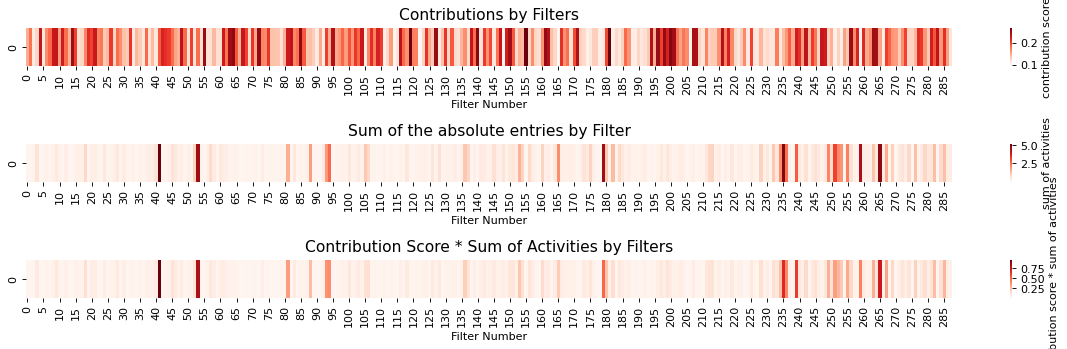

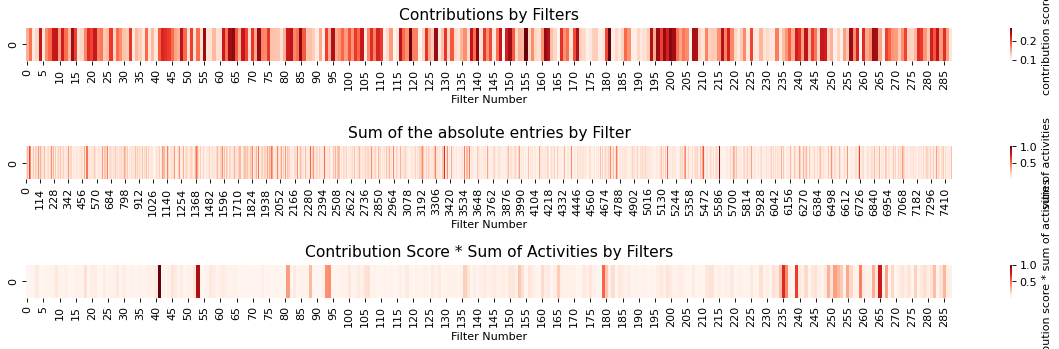

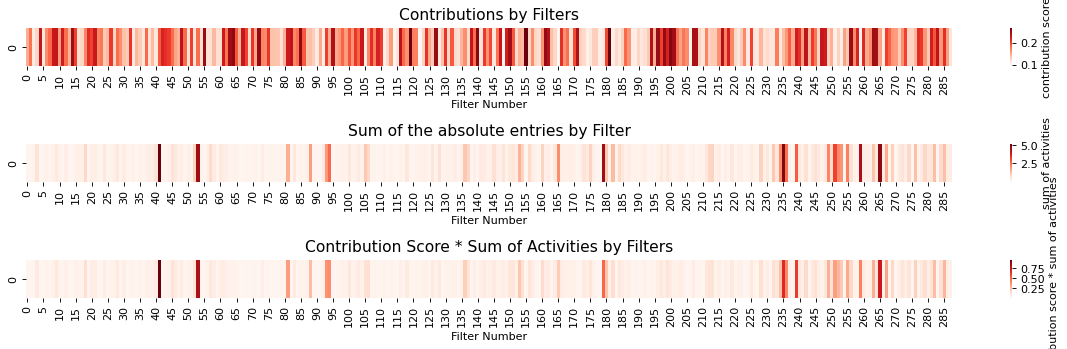

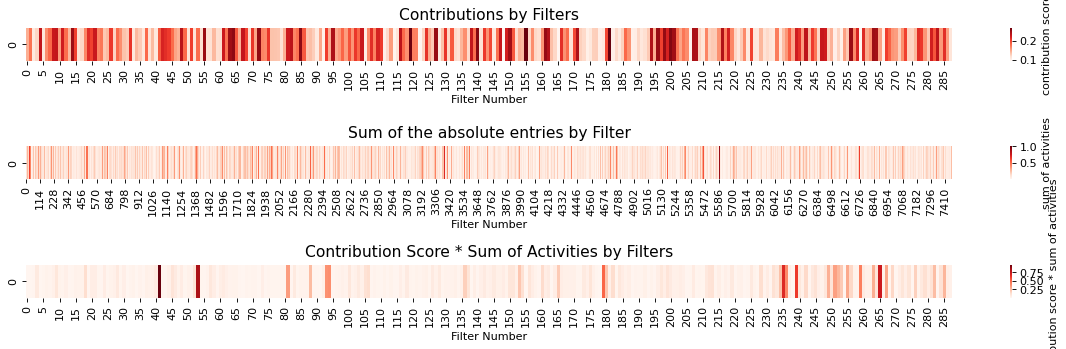

In [159]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 80

# unsqueeze the data to make it compatible with the heatmap function
sum_A_norm = sum_A_norm.reshape(1,-1)
contrib_times_activities = contrib_times_activities.reshape(1,-1)


# only plotting filters, that are within the top 25% of the maximum contribution score
mb.pl.contrib_heatmaps(contributions_normalized,
                       sum_A.reshape(1, -1),
                       contrib_times_activities,
                       cmap='Reds')
                       # (0.66, 11.85, 6.49),
                       # (0.66, 11.85, 6.49)) # vmin values come from the describe() functions

# plotting top 25% of filters normalized
mb.pl.contrib_heatmaps(contributions_normalized,
                       sum_A_norm,
                       contrib_times_activities_norm.reshape(1,-1),
                       cmap='Reds')
                       # vmins=(0.66, 0.14, 0.19),
                       # centers=(0.66, 0.14, 0.19)) # vmin values come from the describe() functions

# plotting all filter
mb.pl.contrib_heatmaps(contributions_normalized,
                       sum_A.reshape(1, -1),
                       contrib_times_activities,
                       cmap='Reds')

# plotting all filters normalized
mb.pl.contrib_heatmaps(contributions_normalized,
                       sum_A_norm,
                       contrib_times_activities,
                       cmap='Reds')

In [153]:
res['graph_score'] = res['filter_id'].map({i : contrib_times_activities[0][i + 2] for i in range(len(contrib_times_activities[0]) - 2)})

CCAAT/CEBP:Nfil3 (0.8269608020782471, 0.2281551736746832)
TFAP2/1:Tfap2c (0.7215534448623657, 0.40731276575577396)
NR/11:Rara (0.9714337587356567, 0.046880766964531397)
SOX/4:Sox9 (0.37844526767730713, -0.5840595867878557)
SOX/3:Sox9 (0.36735641956329346, -0.20797346458899665)
FOX/5:Foxg1 (0.3303365707397461, -0.2865578419682618)
GLI:Gli3 (0.28040337562561035, 0.33447404609390335)
NR/20:Smarcc2 (0.27369368076324463, 0.22877479205818946)
PAX/1:Pax6 (0.23689180612564087, -0.5732369448709101)
RUNX/1:Runx1t1 (0.2057413011789322, -0.27319304915986686)


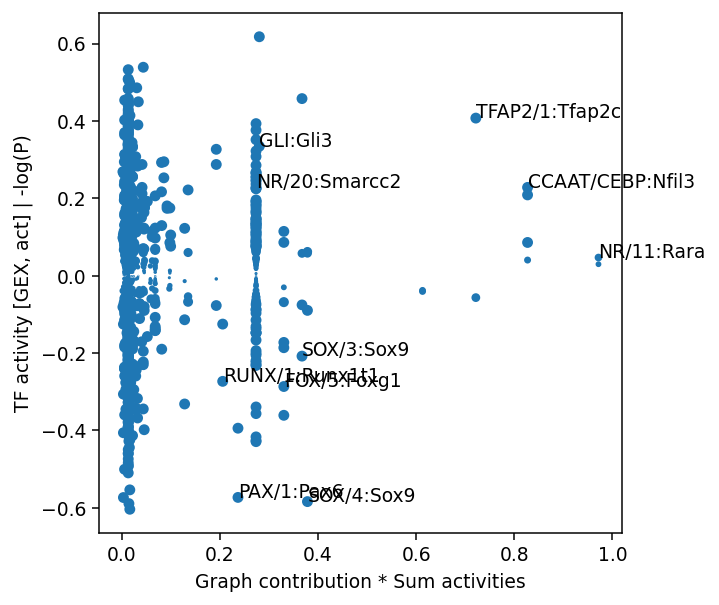

In [156]:
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 135

ax = plt.subplot()
plt.scatter(res['graph_score'], res['spearman'], s=-np.log(res['p_adj'] + 1e-10))
plt.xlabel('Graph contribution * Sum activities')
plt.ylabel('TF activity [GEX, act] | -log(P)')


res['z'] = np.sqrt((res['graph_score'] ** 2) * (-np.log(res['p_adj'] + 1e-10)) ** 2)
res_sel = res.sort_values('z', ascending=False)

res_sel['k'] = res_sel['module_name'] + ':' + res_sel['gene_name']
res_sel = res_sel.drop_duplicates('module_name')

for ri, r in res_sel.head(10).iterrows():
    print(r['module_name'] + ':' + r['gene_name'], (r['graph_score'], r['spearman']))
    ax.annotate(r['module_name'] + ':' + r['gene_name'], (r['graph_score'], r['spearman']))


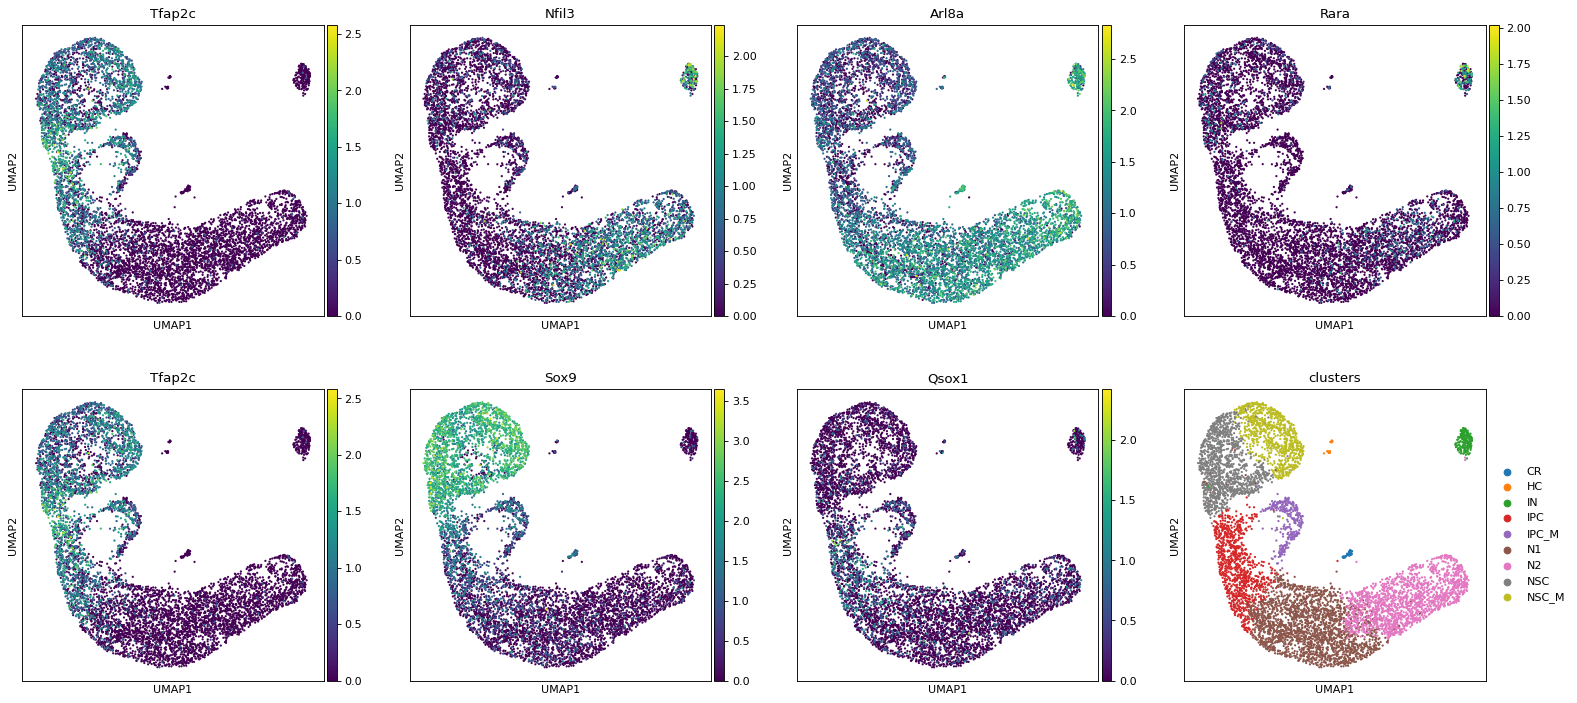

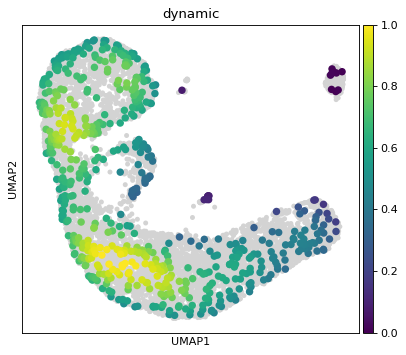

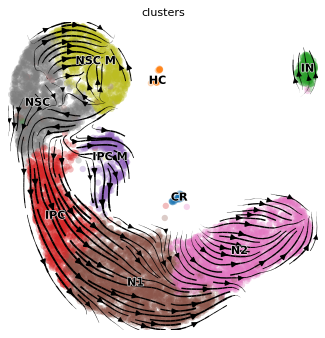

In [162]:
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 80
sc.pl.umap(rna_sample, color=['Tfap2c', 'Nfil3', 'Arl8a', 'Rara', 'Tfap2c', 'Sox9', 'Qsox1', cell_type_key])
# sc.pl.umap(rna_sample, color='dynamic_score_abs', cmap='Reds')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic', color_map='viridis') # basis='umap', groupby='dynamic_score_cluster')
scv.pl.velocity_embedding_stream(rna_sample, color=cell_type_key)